# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Explainability with eli5


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargements

In [4]:
import patat.util.file

filename = 'data/tmp/230603-df_ml.pickle'

df_ml = patat.util.file.pickle_load(filename)

In [5]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

In [7]:
df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


# eli5 Text Explainer
---

## Preprocessing

In [8]:
import patat.util.text

In [9]:
import re

In [10]:
def preprocess(text):
    text = patat.util.text.preprocess(text)
    # Remove numbers
    text = re.sub(r'\d+','',text)
    return text

In [11]:
df_ml['text_p']=df_ml['text'].apply(preprocess)

## Reduction du nombre de paragraphes

In [12]:
nb_parags = 13
def cut_text(text):
    return '\n'.join(text.split('\n')[:nb_parags])

In [13]:
df_ml['text_ml']=df_ml['text_p'].apply(cut_text)

## Entrainement pipeline sur l'ensemble du corpus

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

In [26]:
#classifier = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
classifier = LogisticRegression(C=150, random_state=_rs, max_iter=1000)
#classifier = MLPClassifier()

In [27]:
sw = stopwords[:120]
#sw = stopwords

In [28]:
#vectorizer = TfidfVectorizer(stop_words=sw,ngram_range=(2,3))
vectorizer = TfidfVectorizer(stop_words=sw)

In [29]:
pipe = make_pipeline(vectorizer, classifier)

In [35]:
df_ml = df_ml.sample(frac=1,random_state=_rs)

In [36]:
X = df_ml['text']
y = df_ml['infox']

## Crossvalidation

In [37]:
scores = cross_validate(pipe, X, y, cv=5,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [38]:
df_scores=pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.573730,0.116896,0.780000,0.784314,0.800000,0.849778
1,0.449337,0.129944,0.778523,0.778523,0.783784,0.851171
2,0.606275,0.102521,0.785235,0.780822,0.770270,0.878559
3,0.453664,0.109330,0.805369,0.807947,0.813333,0.870090
4,0.596901,0.109486,0.778523,0.778523,0.773333,0.847387


In [39]:
df_scores.mean()

fit_time         0.535981
score_time       0.113635
test_accuracy    0.785530
test_f1          0.786026
test_recall      0.788144
test_roc_auc     0.859397
dtype: float64

<Figure size 800x600 with 0 Axes>

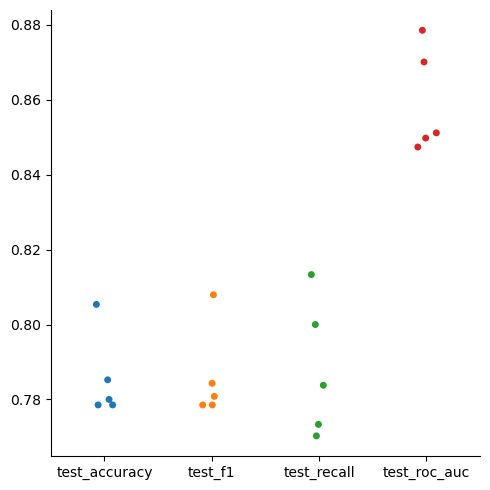

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(data=df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

## Entrainement sur tout le dataset

In [ ]:
pipe.fit(X, y)
pipe.score(X, y)

In [ ]:
import eli5
from eli5.lime import TextExplainer

In [ ]:
df_weights = eli5.format_as_dataframe(eli5.explain_weights(logreg, vec=vectorizer, top=2000,
                   feature_names=vectorizer.get_feature_names_out()))

In [ ]:
df_weights.loc[:100]

In [ ]:
text = df_ml.sample(1).iloc[0]['text']
print(f'Score infox : {pipe.predict_proba([text])[:,1]}\n{text}')

In [ ]:
eli5.show_prediction(logreg, text,
                     vec=vectorizer,
                     feature_names=vectorizer.get_feature_names_out(),
                     target_names=['non_infox','infox'])

In [ ]:
df_ml[df_ml['text_p'].str.contains(r'francesoir')]

In [ ]:
df_weights.to_csv('data/tmp/infox_words.csv')